# Test Re-test analysis

In [1]:
#Import python notebooks
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import scipy.io as sio
import os
import glob
from scipy.stats import norm
import math
# import arviz as az
# import pymc3 as pm
import pandas as pd
from datetime import datetime, timedelta
plt.rcParams.update({'font.size': 16})

## Load the data

In [3]:
#Change the directory
os.chdir('C:\\Users\\Jonathan\\Documents\\GitHub\\Split-Belt-AFC-Reliability\\Data\\TestRetest_PSI')

#Load the data
File_names = glob.glob("*.mat")

print('Files:')

Combined_data = []
for i, f in enumerate(File_names):
    Current_Subject = f[:-9]
    print(f)
    
    D = sio.loadmat(f)
    
    #Change these to 1d instead of 2
    D['AllResponses'] = D['AllResponses'][0]
    D['AllStarts'] = D['AllStarts'][0]
    D['AllStims'] = D['AllStims'][0]
    D['BinaryResponses'] = D['BinaryResponses'][0]
    D['alpha_EV'] = D['alpha_EV'][0]
    D['beta_EV'] = D['beta_EV'][0]

    #Trial Length
    Ntrials = len(D['BinaryResponses'])
    
    #Baseline difference
    D['BslDiff'] = np.ones_like(D['BinaryResponses'])*D['BslDiff'][0]
    #Subject ID and test number
    D['SID'] = [Current_Subject[:-1]]*Ntrials
    D['Test'] = [Current_Subject[-1]]*Ntrials
    
    #Start and end date time
    Test_Start = D.pop('PhaseStart')
    PhaseStart = datetime.strptime(Test_Start[0], "%d-%b-%Y %H:%M:%S")
    Test_Length = timedelta(seconds=D.pop('elapsedTime')[0][0])
    PhaseEnd = PhaseStart+Test_Length
    D['StartTime'] = [PhaseStart]*Ntrials
    D['EndTime'] = [PhaseEnd]*Ntrials
    
    #Delete the unnecessary keys
    del D['__header__'], D['__version__'], D['__globals__']
    
    #Create dataframe 
    currentDF = pd.DataFrame.from_dict(D)
    Combined_data.append(currentDF)
DF = pd.concat(Combined_data)

Files:
PSItest_08a_data.mat
PSItest_08b_data.mat


## Index Start positions and Test length

PSItest_08 a - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_08 b - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )


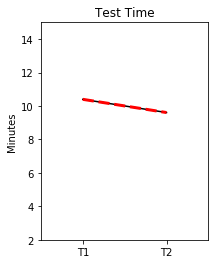

In [22]:
SIDs = pd.unique(DF.SID)
TNs = pd.unique(DF.Test)
Time = []
for i in range(len(SIDs)):
    
    T1 = DF.EndTime[(DF.SID==SIDs[i]) & (DF.Test=='a')][0] - DF.StartTime[(DF.SID==SIDs[i]) & (DF.Test=='a')][0]
    T2 = DF.EndTime[(DF.SID==SIDs[i]) & (DF.Test=='b')][0] - DF.StartTime[(DF.SID==SIDs[i]) & (DF.Test=='b')][0]
    Time.append([T1.total_seconds(), T2.total_seconds()])

    for t in range(len(TNs)):
        
        Starts = DF.AllStarts[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
        Stims = DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
                
        TD = Starts > Stims 
        BU = Starts < Stims
        if sum(TD) == sum(BU):
            print(SIDs[i],  TNs[t], '- Start Positions Equal (Top-Down=', str(sum(TD)), '; Bottom-Up=', str(sum(BU)), ')')
        elif sum(TD) != sum(BU):
            print(SIDs[i],  TNs[t], '- Start Positions Unequal (Top-Down=', str(sum(TD)), '; Bottom-Up=', str(sum(BU)), ')')
    
Time = np.array(Time)    
Time = Time/60

#Plot
plt.figure(figsize=(3,4))
plt.plot([np.ones(len(Time)), np.ones(len(Time))*2], [Time[:,0], Time[:,1]] ,'k-')
plt.plot([1, 2],[np.mean(Time[:,0]), np.mean(Time[:,1])],'r--',lw=3)
plt.xlim(0.5, 2.5)
plt.ylim(2, 15)
plt.xticks([1,2],['T1', 'T2'])
plt.title('Test Time')
plt.ylabel('Minutes')
plt.show()

## Visualize each trial

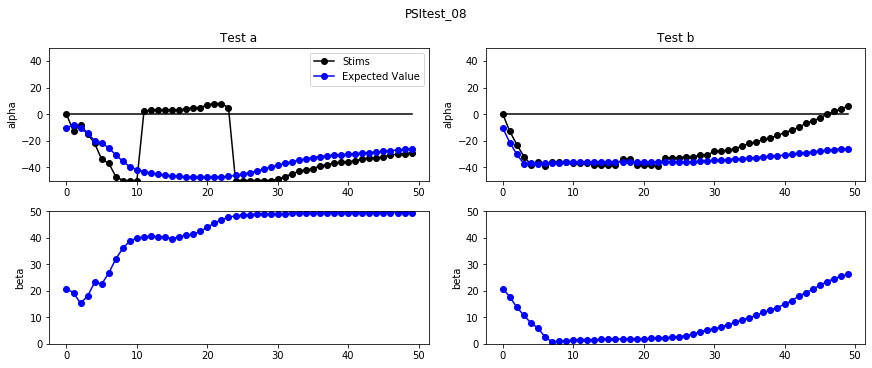

In [30]:
SIDs = pd.unique(DF.SID)
TNs = pd.unique(DF.Test)

for i in range(len(SIDs)):
    fig, ax = plt.subplots(2, 2, constrained_layout=True, figsize=(12,5))
    
    for t in range(len(TNs)):
        BslDiff = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])].values[0])

        Stims = DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]+BslDiff
        Starts = DF.AllStarts[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]+BslDiff
        aEV = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]+BslDiff
        bEV = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
        
        ax[0,t].plot(Stims,'ko-',label='Stims')
        ax[0,t].plot(aEV,'bo-',label='Expected Value')
        ax[0,t].plot(np.zeros(len(Stims)),'k-')
        ax[0,t].set(ylim=(-50,50),ylabel='alpha',title='Test '+ TNs[t])
        if t == 0:
            ax[0,t].legend()
        
        ax[1,t].plot(bEV,'bo-')
        ax[1,t].set(ylim=(0,50),ylabel='beta')
    
    fig.suptitle(SIDs[i])

## Visually compare the two psychometric functions 


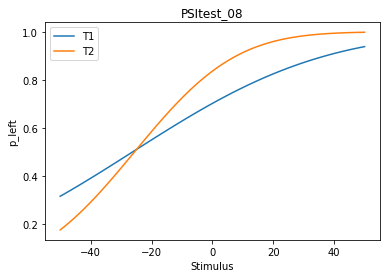

In [45]:
SIDs = pd.unique(DF.SID)
x = np.linspace(-50,50,100) #X-axis 

#initialize for parameters
alphas = []
betas = []
for i in range(len(SIDs)):
    fig, ax = plt.subplots()

    #Index baseline difference
    BD_a = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[0])
    BD_b = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[0])

    #index estimates for test 1 and 2
    aEV_a = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1] + BD_a
    bEV_a = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1]

    aEV_b = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1] + BD_b
    bEV_b = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1]

    #Store the estimates
    alphas.append([aEV_a, aEV_b])
    betas.append([bEV_a, bEV_b])
    
    #Calculate the psychometric functions
    psi_a = norm.cdf(x,aEV_a,bEV_a)
    psi_b = norm.cdf(x,aEV_b,bEV_b)

    #Plot
    ax.plot(x,psi_a,label='T1')
    ax.plot(x,psi_b,label='T2')
    ax.legend()
    ax.set(title=SIDs[i],ylabel='p_left',xlabel='Stimulus')    
    plt.show() 
    
alphas = np.array(alphas)
betas = np.array(betas)

## Compare the parameters

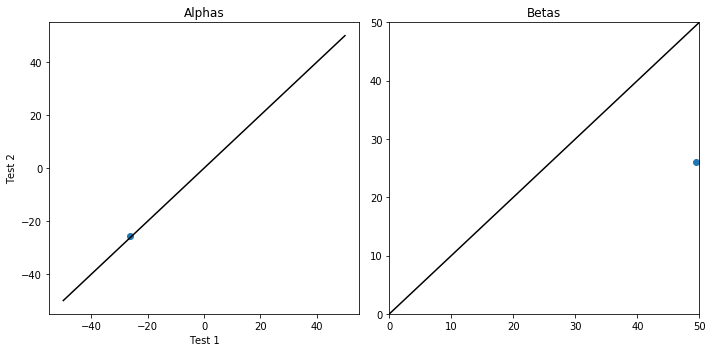

In [38]:
#Calculate CCC


#Plot the parameters
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(alphas[:,0],alphas[:,1],'o')
plt.plot(x,x,'k')
plt.title('Alphas')
plt.xlabel('Test 1')
plt.ylabel('Test 2')

plt.subplot(1,2,2)
plt.plot(betas[:,0],betas[:,1],'o')
plt.plot(x,x,'k')
plt.title('Betas')
plt.ylim(0, 50)
plt.xlim(0, 50)

plt.tight_layout()
plt.show()


## Fit the actual data as a spot check

In [47]:
DF.head()

,AllResponses,AllStarts,AllStims,BinaryResponses,BslDiff,alpha_EV,beta_EV,SID,Test,StartTime,EndTime
0,[l],20,0,1,0.0,-10.528465,20.821217,PSItest_08,a,2022-03-16 08:24:25,2022-03-16 08:34:48.880295
1,[r],-43,-13,0,0.0,-7.864294,19.192946,PSItest_08,a,2022-03-16 08:24:25,2022-03-16 08:34:48.880295
2,[l],-72,-8,1,0.0,-10.584309,15.296340,PSItest_08,a,2022-03-16 08:24:25,2022-03-16 08:34:48.880295
3,[l],-53,-15,1,0.0,-14.477176,17.955442,PSItest_08,a,2022-03-16 08:24:25,2022-03-16 08:34:48.880295
4,[l],-98,-22,1,0.0,-19.977956,23.162475,PSItest_08,a,2022-03-16 08:24:25,2022-03-16 08:34:48.880295


[-50. -49. -47. -45. -43. -42. -41. -39. -38. -37. -36. -35. -34. -33.
 -32. -31. -30. -29. -22. -15. -13.  -8.   0.   2.   3.   4.   5.   7.
   8.]


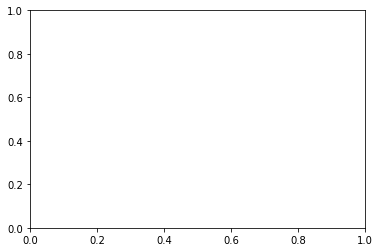

In [59]:
SIDs = pd.unique(DF.SID)
x = np.linspace(-50,50,100) #X-axis 

#initialize parameters
alphas = []
betas = []
for i in range(len(SIDs)):
    fig, ax = plt.subplots()

    #Index the responses
    Responses = DF.BinaryResponses[(DF.SID==SIDs[i])]
    
    #Index baseline difference
    BD_a = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[0])
    BD_b = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[0])
    
    #Index the stimuli
    Stims_a = DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test=='a')] + BD_a
    Stims_b = DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test=='a')] + BD_b
    
    Stims = np.concatenate((Stims_a,Stims_b))
    
    #Control for repeated stimuli 
    print(np.unique(Stims))
    
#     print(Stims)
    
    

#     #index estimates for test 1 and 2
#     aEV_a = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1] + BD_a
#     bEV_a = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1]

#     aEV_b = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1] + BD_b
#     bEV_b = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1]

#     #Store the estimates
#     alphas.append([aEV_a, aEV_b])
#     betas.append([bEV_a, bEV_b])
    
#     #Calculate the psychometric functions
#     psi_a = norm.cdf(x,aEV_a,bEV_a)
#     psi_b = norm.cdf(x,aEV_b,bEV_b)

#     #Plot
#     ax.plot(x,psi_a,label='T1')
#     ax.plot(x,psi_b,label='T2')
#     ax.legend()
#     ax.set(title=SIDs[i],ylabel='p_left',xlabel='Stimulus')    
#     plt.show() 
    
# alphas = np.array(alphas)
# betas = np.array(betas)